In [2]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

In [3]:
def connectLines(mat, pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2

    dx = x2-x1
    dy = y2-y1

    sx = np.sign(dx)
    sy = np.sign(dy)

    vec = [dx , dy]

# vec = [12, 0]
    ratioX = abs(vec[0]/sum(map(abs, vec)))
    ratioY = abs(vec[1]/sum(map(abs, vec)))
# print(f"Ratio X: {ratioX} Y: {ratioY}")
    # ratio = abs
    # print(60*"*")
    # print("Starting Image")
    # print(60*"*")
    # print(mat)
    # print(f"Starting dx:{dx} starting dy:{dy}") 
    while dx != 0 or dy != 0:
        r = random.random()
        # print(f"r = {r}")
        if r < ratioX and dx:
            mat[x1+dx][y1+dy] = 1
            dx -= sx
            # print(f"xdir: {x1+dx}")
        elif dy:
            mat[x1+dx][y1+dy] = 1
            dy -= sy
            # print(f"ydir {y1+dy}")
    # print(60*"*")
    # print("Final Image")
    # print(60*"*")
    # print(mat)
            

In [4]:
a = np.zeros((700,400), int)
pt1 = (3, 2)
pt2 = (699, 387)
a[pt1] = 1
a[pt2] = 1
connectLines(a, pt1, pt2)

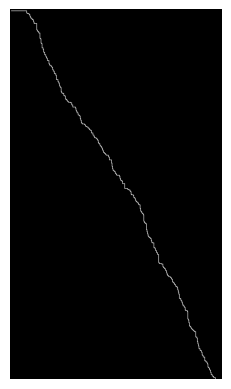

In [5]:
# plt.plot(a)
plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()

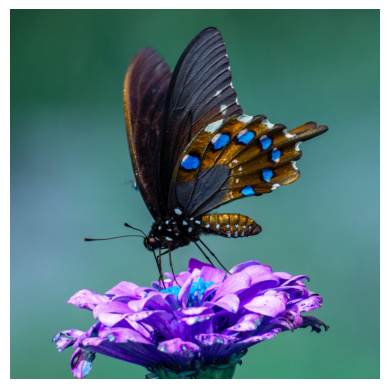

In [6]:
img = cv2.imread('./butterfly.jpeg')
plt.imshow(img)
plt.axis('off')
plt.show()

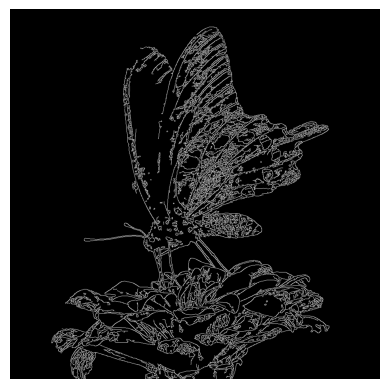

In [76]:
t_lower = 20  
t_upper = 170 

edge = cv2.Canny(img, t_lower, t_upper,  L2gradient = True)
plt.imshow(edge, cmap='gray')
plt.axis('off')
plt.show()